In [1]:
import numpy as np 
from astropy.io import fits
import sim_util as su
import scipy.signal as signal
import kappa_util as ul 

In [2]:
#load kappa (convergence) map
data_path = '../manga_mass_0/mge_kappa/kappa'
data_name = '1016_8318-12701'
kappa_high_res  = fits.getdata(f'{data_path}/{data_name}.fits',0)
header = fits.getheader(f'{data_path}/{data_name}.fits',0)
dpix_high_res = header['dpix']  #subgrid pixel size in arcsec unit
subgrid = header['nsub']  #number of sub-pixels for each native ccd pixel
print('the initial kappa map size is:', kappa_high_res.shape)
print('the initial kappa map pixel size in arcsec unit is:', dpix_high_res)
print(f'when calculating deflection from the kappa, we do a {subgrid}X{subgrid} binning')

the initial kappa map size is: (1600, 1600)
the initial kappa map pixel size in arcsec unit is: 0.025
when calculating deflection from the kappa, we do a 2X2 binning


In [3]:
#calculate defelction angle map (alpha-map) from kappa map
alphax_lowres, alphay_lowres = ul.alpha_from_kappa_adp(kappa_high_res, dpix_high_res, subgrid)
print('the defleciton angle we get have a shape of:', alphax_lowres.shape)
#we only use inner most region, to avoid the boundary effect that would produce the pesudo shearing
alphax_lowres = su.cut_image(alphax_lowres,(200,200))
alphay_lowres = su.cut_image(alphay_lowres,(200,200))

the defleciton angle we get have a shape of: (800, 800)


In [4]:
#generate image-plane grid
x_grid_lowres, y_grid_lowres = su.make_grid_2d(alphax_lowres.shape[0], dpix=dpix_high_res*subgrid)
#ray-trace image-plane grid to source-plane
xsource = x_grid_lowres - alphax_lowres 
ysource = y_grid_lowres - alphay_lowres

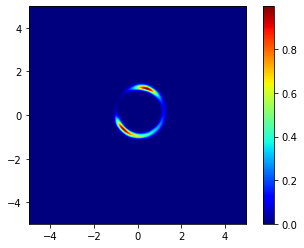

In [5]:
#suppose the light distribution of the background source galaxy is a simple spherical gauss
ideal_lensed_image = su.gauss_2d(xsource, ysource, 0.1, 0.2, 0.1, 1.0) #no psf, noise etc
#show figure
ext  = [x_grid_lowres.min(), x_grid_lowres.max(), y_grid_lowres.min(), y_grid_lowres.max()]
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(ideal_lensed_image, cmap='jet', origin='lower', extent=ext)
plt.colorbar()
plt.show() 

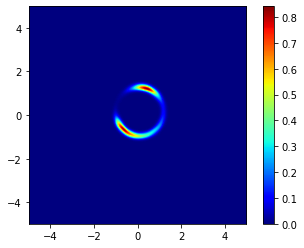

In [6]:
# let us convolve this ideal image with the psf
x_psf, y_psf = su.make_grid_2d(15, dpix=dpix_high_res*subgrid) #the psf grid, 11X11 grid, with pixel size of 0.05 arcsec
psf = su.gauss_2d(x_psf, y_psf, 0.0, 0.0, 0.05, 1.0) #we use a gauss model to represent the psf, the width (sigma) of psf is set to 0.05 arcsec
psf /= psf.sum() #normalized the psf
blur_lensed_image = signal.convolve2d(ideal_lensed_image, psf, mode='same') #convolve the image with psf

plt.figure()
plt.imshow(blur_lensed_image, cmap='jet', origin='lower', extent=ext)
plt.colorbar()
plt.show() 

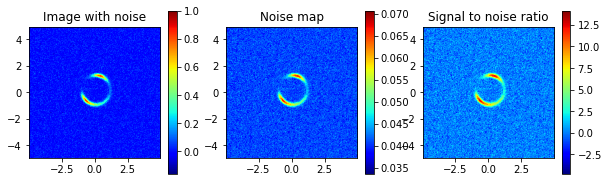

In [7]:
noisy_image, noise_map = su.add_noise_to_image(
    ideal_image=blur_lensed_image, #the ideal image without the noise, unit e-/s/pix; 
    # in this example, we do not include the lens light to the lensing image; so the ideal_image is the lensed arc image only.
    skylevel=0.5, #the sky-backgroud level in e-/s/pix
    exposure=300, #the exposure time in sec
    add_noise=True, #if add a noise realization to the mock image
)

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(noisy_image, cmap='jet', origin='lower', extent=ext)
plt.colorbar()
plt.title('Image with noise')
plt.subplot(132)
plt.imshow(noise_map, cmap='jet', origin='lower', extent=ext)
plt.colorbar()
plt.title('Noise map')
plt.subplot(133)
plt.imshow(noisy_image/noise_map, cmap='jet', origin='lower', extent=ext)
plt.colorbar()
plt.title('Signal to noise ratio')
plt.show() 

In [8]:
## write image/noise/psf to a fits, then you can model them with pyautolens
"""
fits.writeto('image_map.fits', noisy_image)
fits.writeto('noise_map.fits', noise_map)
fits.writeto('psf_map.fits', psf)
"""

"\nfits.writeto('image_map.fits', noisy_image)\nfits.writeto('noise_map.fits', noise_map)\nfits.writeto('psf_map.fits', psf)\n"